# ARPA Weather Station Data
This notebook is used for:
1) testing ARPA API functionalities
2) testing functions to be implemented in the plugin
3) testing libraries to be used and evaluate performances

First, it is necessary to get a token.
Go to Open Data Lombardia website (https://dati.lombardia.it/). Subscribe to the website and go to your profile settings. <br>
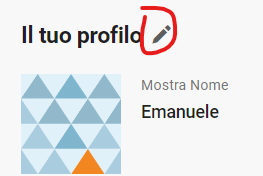 <br>
Modify your profile and open the "Opzioni per lo sviluppatore" tab. Create a new App Token to be used.


Useful notebook for Sodapy: https://github.com/xmunoz/sodapy/blob/master/examples/soql_queries.py

## Import libraries

In [1]:
from sodapy import Socrata
import pandas as pd
from datetime import datetime, timedelta
import requests
from io import BytesIO
from zipfile import ZipFile
import os
import time
import dask.dataframe as dd

## Client

In [2]:
arpa_token = "riTLzYVRVdDaQtUkxDDaHRgJi" 
print(arpa_token)

riTLzYVRVdDaQtUkxDDaHRgJi


Pandas va installato anche se si installa prima Dask

Function to create a client session with the API using the token:

In [3]:
def connect_ARPA_api(token):
    """
    Function to connect to ARPA API.

        Parameters:
            - token (str): the ARPA token obtained from Open Data Lombardia website

        Returns:
            - client: client session
            
    """
    client = Socrata("www.dati.lombardia.it", app_token=token)

    return client

Import the code of the dataset. In this case "nf78-nj6b" is related to ARPA stations information containing:
1) sensors id
2) sensor type
3) unit
4) stations id
5) stations names
...

## Stations and sensors information

In [4]:
stationsId = "nf78-nj6b" # Select meteo stations dataset containing positions and information about sensors
client = connect_ARPA_api(arpa_token)
sensors_info = client.get_all(stationsId)

Create sensors dataframe:

In [5]:
def ARPA_sensors_info(sensors_info):
    
    sensors_df = pd.DataFrame(sensors_info)
    sensors_df['idsensore']=sensors_df['idsensore'].astype(int)
    sensors_df['idstazione']=sensors_df['idstazione'].astype(int)
    sensors_df['datastart']=pd.to_datetime(sensors_df['datastart'])
    sensors_df['datastop']=pd.to_datetime(sensors_df['datastop'])
    
    
    
    return sensors_df

In [6]:
sensors_df = ARPA_sensors_info(sensors_info)

In [7]:
sensors_df.dtypes

idsensore                               int32
tipologia                              object
unit_dimisura                          object
idstazione                              int32
nomestazione                           object
quota                                  object
provincia                              object
datastart                      datetime64[ns]
storico                                object
cgb_nord                               object
cgb_est                                object
lng                                    object
lat                                    object
location                               object
:@computed_region_6hky_swhk            object
:@computed_region_ttgh_9sm5            object
datastop                       datetime64[ns]
dtype: object

In [8]:
# #Check sensori storici
# sensors_df.loc[sensors_df['storico'] == 'S']

Consideration: inside the plugin the data type for each columns must be set accordingly to QGIS data types.

Select sensor type and create a list of those sensors from the previous dataframe.

In [9]:
sensor_sel = "Temperatura"
sensors_list = (sensors_df.loc[sensors_df['tipologia'] == sensor_sel]).idsensore.tolist()  #& (sensors_df['storico'] == storic_data)
sensors_list = list(map(int, sensors_list))

In [10]:
print(("Selected sensor: {sel}").format(sel=sensor_sel))
print(("Number of selected sensor: {sens_len}").format(sens_len=len(sensors_list)))

Selected sensor: Temperatura
Number of selected sensor: 248


----

## API Time series
This part requires time series and relative information from the API. The output of this section is to obtain a dataframe that has the same characteristics as the dataframe obtained from the csv processing.

In [11]:
def req_ARPA_start_end_date_API(client):
    """
    Function to request the start and the end date of data available in the ARPA API.

      Parameters:
        - client: the client session

      Returns: 
        - start_API_date (str): starting date for available data inside the API.
        - end_API_date (str): ending date for available data inside the API.
        
    """
    weather_sensor_id = "647i-nhxk" #Weather sensors id
    query = """ select MAX(data), MIN(data) limit 9999999999999999"""

    min_max_dates = client.get(weather_sensor_id, query=query)[0] #Get max and min dates from the list
    
    #Start and minimum dates from the dict obtained from the API
    start_API_date = min_max_dates['MIN_data']
    end_API_date = min_max_dates['MAX_data']
    
    #Convert to datetime and add 1 day to end date to consider all the values inside the last day (e.g. 20/01/2023 23:10:00 won't be considered and the requested data will be untile 20/01/2023 00:00:00)
    start_API_date = datetime.strptime(start_API_date, "%Y-%m-%dT%H:%M:%S.%f")
    end_API_date = datetime.strptime(end_API_date, "%Y-%m-%dT%H:%M:%S.%f")
    
    print("The data from the API are available from: " ,start_API_date, " up to: ", end_API_date)

    return start_API_date, end_API_date

In [12]:
start_date_API, end_date_API = req_ARPA_start_end_date_API(client)

The data from the API are available from:  2023-01-01 00:00:00  up to:  2023-01-20 12:00:00


In [13]:
start_date_API, end_date_API

(datetime.datetime(2023, 1, 1, 0, 0), datetime.datetime(2023, 1, 20, 12, 0))

In [14]:
# #In this way can be manually defined otherwise minimum and max dates are selected as previsously shown
# start_date_API = "2023-01-17 05:00:00"
# end_date_API = "2023-01-19 10:00:00"
# start_date_API = datetime.strptime(start_date_API, "%Y-%m-%d %H:%M:%S")
# end_date_API = datetime.strptime(end_date_API, "%Y-%m-%d %H:%M:%S")
# start_date_API, end_date_API

Function to request the time series from the API in the time range considered:

In [15]:
def req_ARPA_data_API(client, start_date, end_date, sensors_list):
    """
    Function to request data from available weather sensors in the ARPA API using a query.

      Parameters:
        - client: the client session
        - start date (str): the start date in yyy-mm-dd format
        - end date (str): the end date in yyy-mm-dd format
        - sensors_list(str): list of sensors selected to be used as filter
        
      Returns: 
        - time_series: time series of values requested with the query for all sensors
        
    """
    weather_sensor_id = "647i-nhxk"
    
    #Convert to string in year-month-day format, accepted by ARPA query
    start_date = start_date.strftime("%Y-%m-%dT%H:%M:%S.%f")
    end_date = end_date.strftime("%Y-%m-%dT%H:%M:%S.%f")
    
    t = time.time()
    
    query = """
      select
          *
      where data >= \'{}\' and data <= \'{}\' limit 9999999999999999
      """.format(start_date, end_date)

    time_series = client.get(weather_sensor_id, query=query)
    print(time_series)
    elapsed = time.time() - t
    print("Time used for requesting the data from ARPA API: ", elapsed)
    
    #Create dataframe
    sensors_values_df_API = pd.DataFrame(time_series, columns=['idsensore','data','valore'])
    
    #Convert types
    sensors_values_df_API['valore'] = sensors_values_df_API['valore'].astype(float)
    sensors_values_df_API['idsensore'] = sensors_values_df_API['idsensore'].astype(int)
    sensors_values_df_API['data'] = pd.to_datetime(sensors_values_df_API['data'])
    sensors_values_df_API = sensors_values_df_API.sort_values(by='data', ascending=True).reset_index(drop=True)
    
    #Filter with selected sensors list
    sensors_values_df_API = sensors_values_df_API[sensors_values_df_API['idsensore'].isin(sensors_list)]

    return sensors_values_df_API

Output dataframe:
- idsensore (int)
- data (datetime)
- valore (float)

In [16]:
sensors_values_API = req_ARPA_data_API(client, start_date_API, end_date_API, sensors_list)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [17]:
sensors_values_API.dtypes

idsensore             int32
data         datetime64[ns]
valore              float64
dtype: object

Final dataframe:

In [18]:
sensors_values_API

,idsensore,data,valore
1,5890,2023-01-01 00:00:00,7.4
2,5890,2023-01-01 01:00:00,7.3
4,5890,2023-01-01 02:00:00,7.3
7,5890,2023-01-01 03:00:00,7.4
8,5890,2023-01-01 04:00:00,7.4
...,...,...,...
2343230,19401,2023-01-20 11:50:00,-3.1
2343243,19333,2023-01-20 11:50:00,2.7
2343245,19415,2023-01-20 11:50:00,1.7
2343247,19441,2023-01-20 11:50:00,4.7


---

## Time series from csv files
The output of this sections is a dataframe that has the same characteristics of the time series obtained with the API.

In [19]:
def download_extract_csv_from_year(year):
    """
    Function for selecting the correct link for downloading zipped .csv meteorological data from ARPA sensors and extracting it.

    For older data it is necessary to download this .csv files containing the time series of the meteorological sensors.

            Parameters:
                year(str): the selected year for downloading the .csv file containing the meteorological sensors time series

            Returns:
                None
    """
    
    #Create a dict with years and link to the zip folder on Open Data Lombardia
    switcher = {
        '2022': "https://www.dati.lombardia.it/download/mvvc-nmzv/application%2Fzip",
        '2021': "https://www.dati.lombardia.it/download/49n9-866s/application%2Fzip",
        '2020': "https://www.dati.lombardia.it/download/erjn-istm/application%2Fzip",
        '2019': "https://www.dati.lombardia.it/download/wrhf-6ztd/application%2Fzip",
        '2018': "https://www.dati.lombardia.it/download/sfbe-yqe8/application%2Fzip",
        '2017': "https://www.dati.lombardia.it/download/vx6g-atiu/application%2Fzip"
    }
    
    #Select the url and make request
    url = switcher[year]
    filename = 'meteo_'+str(year)+'.zip'
    
    print(('Downloading {filename} -> Started. It might take a while... Please wait!').format(filename = filename))
    req = requests.get(url)
    
    # Writing the file to the local file system
    with open(filename,'wb') as output_file:
        output_file.write(req.content)
    print(('Downloading {filename} -> Completed').format(filename = filename))
    
    print(("Starting unzipping: {filename}").format(filename=filename))
    #Loading the .zip and creating a zip object
    with ZipFile(filename, 'r') as zObject:
        # Extracting all the members of the zip into a specific location
        zObject.extractall()
    
    csv_file=str(year)+'.csv'
    print(("File unzipped: {filename}").format(filename=filename))
    print(("File csv saved: {filename}").format(filename=csv_file))
    
    #Remove the zip folder
    if os.path.exists(filename):
        print("Zip folder removed")
        os.remove(filename)
    else:
        print(("The file {filename} does not exist in this folder").format(filename=filename))

In [20]:
year = 2022
csv_file = str(year)+'.csv'

Make an if that it doenst download the file if the csv is already present.

In [21]:
download_extract_csv_from_year(str(year))

Starting unzipping: meteo_2022.zip
File unzipped: meteo_2022.zip
File csv saved: 2022.csv
Zip folder removed


In [22]:
start_date_csv = str(year)+"-06-01 05:00:00"
end_date_csv = str(year)+"-06-30 10:00:00"
start_date_csv = datetime.strptime(start_date_csv, "%Y-%m-%d %H:%M:%S")
end_date_csv = datetime.strptime(end_date_csv, "%Y-%m-%d %H:%M:%S")
start_date_csv, end_date_csv

(datetime.datetime(2022, 6, 1, 5, 0), datetime.datetime(2022, 6, 30, 10, 0))

Create a function that prepares the dataframe. Function to process the csv file using Dask library to manage big files. 
- proper columns names like the API ones
- removes useless columns
- converts to rfifodata tydd
- filters over the time range
- filters with selected sensor list
- compute dask dataframe

In [23]:
def process_ARPA_csv(csv_file, start_date, end_date, sensors_list):
    """
    This function reads the ARPA csv file into a dask dataframe and provided a computed dataframe. It renames the columns like the API columns names, filters between provided dates and select the sensors present in the list.

            Parameters:
                csv_file(str): name of the csv file
                start_date(datetime): start date for processing
                end_date(datetime): end date for processing
                sensors_list(string list): list of selected sensors

            Returns:
                df(dataframe): computed filtered dask dataframe
    """
    
    print(("The time range is {start_date} to {end_date}").format(start_date=start_date,end_date=end_date))
    #Read csv file with Dask dataframe
    df = dd.read_csv(csv_file, usecols=['IdSensore','Data','Valore']) 
    
    #Make csv columns names equal to API columns names
    df = df.rename(columns={'IdSensore': 'idsensore', 'Data': 'data', 'Valore': 'valore'})
    
    #Type formatting
    df['valore'] = df['valore'].astype(float)
    df['idsensore'] = df['idsensore'].astype(int)
    df['data'] = dd.to_datetime(df.data, format='%d/%m/%Y %H:%M:%S')
    
    #Filter using the dates
    df = df.loc[(df['data'] >= start_date) & (df['data'] <= end_date)]
    df['data'] = dd.to_datetime(df.data, format='%d/%m/%Y %H:%M:%S')
    #Filter on temperature sensors list
    sensors_list = list(map(int, sensors_list))
    df = df[df['idsensore'].isin(sensors_list)]
    
    print("Starting computing dataframe")
    #Compute df
    t = time.time()
    df = df.compute()
    elapsed = time.time() - t
    print("Time used for computing dataframe: ", elapsed)
    
    return df 

In [24]:
sensors_values_csv = process_ARPA_csv(csv_file, start_date_csv, end_date_csv, sensors_list)

The time range is 2022-06-01 05:00:00 to 2022-06-30 10:00:00
Starting computing dataframe
Time used for computing dataframe:  32.860800981521606


In [25]:
sensors_values_csv.dtypes

idsensore             int32
data         datetime64[ns]
valore              float64
dtype: object

Final dataframe:

In [26]:
sensors_values_csv

,idsensore,data,valore
1934686,53,2022-06-01 05:00:00,5.8
1934698,115,2022-06-01 05:00:00,5.9
1934700,121,2022-06-01 05:00:00,10.5
1934711,2001,2022-06-01 05:00:00,15.5
1934715,2039,2022-06-01 05:00:00,17.2
...,...,...,...
1012457,32370,2022-06-30 10:00:00,20.6
1012464,32391,2022-06-30 10:00:00,25.4
1012468,32401,2022-06-30 10:00:00,15.1
1012484,12025,2022-06-30 10:00:00,29.8


## Data aggregation

Function to aggregate the data in the dataframe. Both API and csv data can be aggregated.
Must provide a dataframe with idsensore (int), data (datetime), valore (float).
- Temporal aggregation: day, month, year etc.
- Aggregation function: mean, max, min etc.
- Sensor id aggregation (idsensore)



In [27]:
def aggregate_group_data(df, temporal_agg="D", agg="mean"):

    """
    This function aggregates ARPA data with providing a temporal aggregation (day, week etc.) and a statistical aggregration function (mean, max, min etc.). The dataframe is grouped by sensor id (idsensore).

            Parameters:
                df(dataframe): ARPA dataframe containing the following columns: "idsensore"(int), "data"(datetime) and "valore"(float)
                temporal_agg(str): the temporal aggregation accepted by the resample() method (D, M, Y or others)
                agg(str): the statistical aggregation to be performed (mean, max, min etc.)

            Returns:
                df(dataframe): computed filtered and aggregated dask dataframe
    """
    
    print("Number of sensors available in the dataframe: ", len(df.idsensore.unique()))
    print("Aggregation function: " + agg)
    print("Temporal aggregation: " + temporal_agg)
    df = df.set_index('data')
          
    grouped = df.groupby('idsensore').resample(str(temporal_agg))['valore'].agg(str(agg))
    grouped = grouped.reset_index()
    
    return grouped

Use the function to aggregate and group the data. You can pass the value obtained from the API or the values obtaines from the csv.

In [28]:
sensor_test_agg = aggregate_group_data(sensors_values_csv, "D", "mean")

Number of sensors available in the dataframe:  196
Aggregation function: mean
Temporal aggregation: D


In [29]:
sensor_test_agg

,idsensore,data,valore
0,53,2022-06-01,10.568421
1,53,2022-06-02,12.273611
2,53,2022-06-03,10.370833
3,53,2022-06-04,14.179861
4,53,2022-06-05,13.559028
...,...,...,...
5870,32401,2022-06-26,14.734028
5871,32401,2022-06-27,17.159722
5872,32401,2022-06-28,15.528472
5873,32401,2022-06-29,14.087500


## Test and plotting

Select a specific sensor:

In [30]:
sel_sensor = sensor_test_agg.loc[sensor_test_agg['idsensore']==2039]

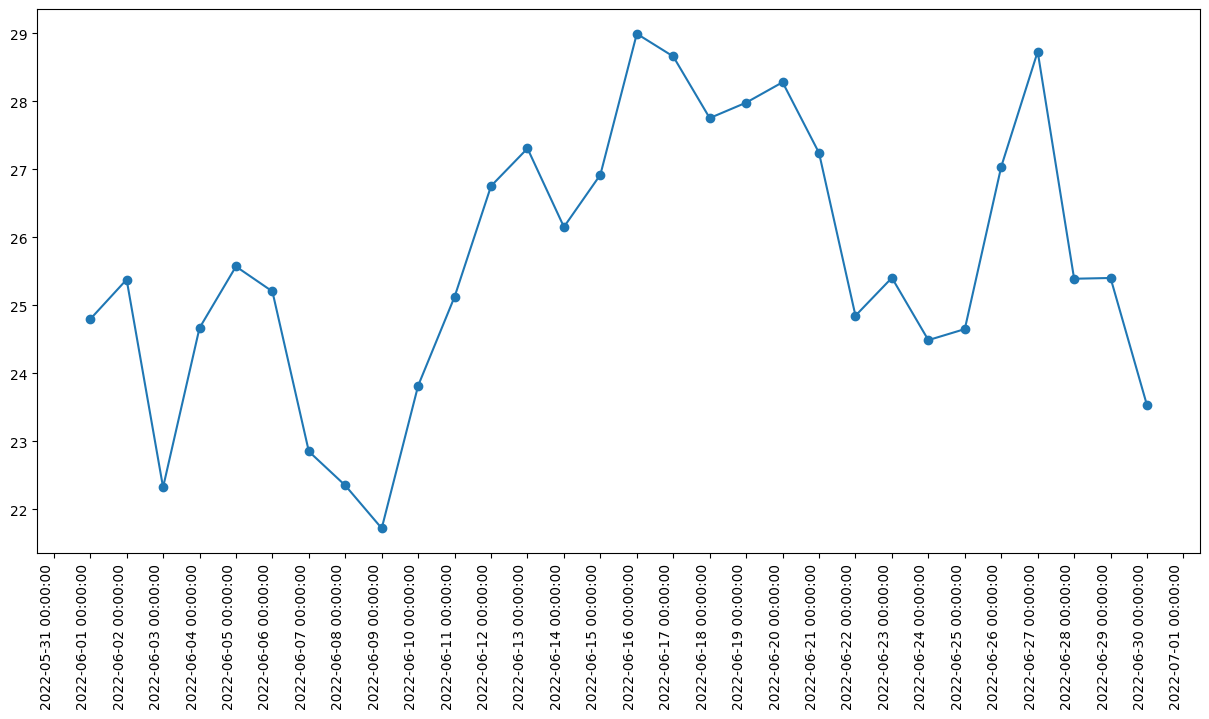

In [31]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
import matplotlib.dates as mdates

plt.figure(figsize=(15,8))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gcf().autofmt_xdate()
plt.xticks(rotation=90)
plt.plot(sel_sensor['data'],sel_sensor['valore'], '-',  marker='o')

## Join sensors information and time series 
Once the dataframes are created is possible to merge the information.

In [32]:
sensors_df

,idsensore,tipologia,unit_dimisura,idstazione,nomestazione,quota,provincia,datastart,storico,cgb_nord,cgb_est,lng,lat,location,:@computed_region_6hky_swhk,:@computed_region_ttgh_9sm5,datastop
0,10373,Precipitazione,mm,687,Ferno v.Di Dio,215,VA,2007-08-13,N,5051773,481053,8.756970445453431,45.61924377994763,"{'latitude': '45.61924377994763', 'longitude':...",1,1,NaT
1,10376,Precipitazione,mm,706,Lecco v.Sora,272,LC,2008-07-22,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaT
2,10377,Temperatura,°C,706,Lecco v.Sora,272,LC,2008-07-22,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaT
3,10381,Umidità Relativa,%,706,Lecco v.Sora,272,LC,2008-07-22,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaT
4,10382,Radiazione Globale,W/m²,706,Lecco v.Sora,272,LC,2008-07-31,N,5078987,531045,9.399950344681852,45.86374884127965,"{'latitude': '45.86374884127965', 'longitude':...",10,10,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,9869,Umidità Relativa,%,672,Cornale v.Libertà,74,PV,2005-07-28,N,4987406,493238,8.914144599002409,45.04007657202963,"{'latitude': '45.04007657202963', 'longitude':...",7,7,NaT
1228,9933,Precipitazione,mm,677,Cremona Via Fatebenefratelli,43,CR,2006-04-10,N,4999315,582066,10.043836158369393,45.14254063221695,"{'latitude': '45.14254063221695', 'longitude':...",8,8,NaT
1229,9935,Radiazione Globale,W/m²,677,Cremona Via Fatebenefratelli,43,CR,2006-04-10,N,4999315,582066,10.043836158369393,45.14254063221695,"{'latitude': '45.14254063221695', 'longitude':...",8,8,NaT
1230,9938,Temperatura,°C,677,Cremona Via Fatebenefratelli,43,CR,2006-04-10,N,4999315,582066,10.043836158369393,45.14254063221695,"{'latitude': '45.14254063221695', 'longitude':...",8,8,NaT


In [33]:
sensor_test_agg

,idsensore,data,valore
0,53,2022-06-01,10.568421
1,53,2022-06-02,12.273611
2,53,2022-06-03,10.370833
3,53,2022-06-04,14.179861
4,53,2022-06-05,13.559028
...,...,...,...
5870,32401,2022-06-26,14.734028
5871,32401,2022-06-27,17.159722
5872,32401,2022-06-28,15.528472
5873,32401,2022-06-29,14.087500


In [34]:
merged_df = pd.merge(sensor_test_agg, sensors_df, on='idsensore')

In [35]:
merged_df['lng'] = merged_df['lng'].astype(float)
merged_df['lat'] = merged_df['lat'].astype(float)

In [36]:
merged_df

,idsensore,data,valore,tipologia,unit_dimisura,idstazione,nomestazione,quota,provincia,datastart,storico,cgb_nord,cgb_est,lng,lat,location,:@computed_region_6hky_swhk,:@computed_region_ttgh_9sm5,datastop
0,53,2022-06-01,10.568421,Temperatura,°C,28,Chiesa in Valmalenco Alpe Entova,1905,SO,1989-10-28,N,5130098,564213,9.834123,46.321415,"{'latitude': '46.32141528836431', 'longitude':...",3,3,NaT
1,53,2022-06-02,12.273611,Temperatura,°C,28,Chiesa in Valmalenco Alpe Entova,1905,SO,1989-10-28,N,5130098,564213,9.834123,46.321415,"{'latitude': '46.32141528836431', 'longitude':...",3,3,NaT
2,53,2022-06-03,10.370833,Temperatura,°C,28,Chiesa in Valmalenco Alpe Entova,1905,SO,1989-10-28,N,5130098,564213,9.834123,46.321415,"{'latitude': '46.32141528836431', 'longitude':...",3,3,NaT
3,53,2022-06-04,14.179861,Temperatura,°C,28,Chiesa in Valmalenco Alpe Entova,1905,SO,1989-10-28,N,5130098,564213,9.834123,46.321415,"{'latitude': '46.32141528836431', 'longitude':...",3,3,NaT
4,53,2022-06-05,13.559028,Temperatura,°C,28,Chiesa in Valmalenco Alpe Entova,1905,SO,1989-10-28,N,5130098,564213,9.834123,46.321415,"{'latitude': '46.32141528836431', 'longitude':...",3,3,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,32401,2022-06-26,14.734028,Temperatura,°C,1680,Vilminore di Scalve Presolana,1856,BG,2017-11-15,N,5092483,580679,10.041578,45.981172,"{'latitude': '45.98117244427475', 'longitude':...",5,5,NaT
5871,32401,2022-06-27,17.159722,Temperatura,°C,1680,Vilminore di Scalve Presolana,1856,BG,2017-11-15,N,5092483,580679,10.041578,45.981172,"{'latitude': '45.98117244427475', 'longitude':...",5,5,NaT
5872,32401,2022-06-28,15.528472,Temperatura,°C,1680,Vilminore di Scalve Presolana,1856,BG,2017-11-15,N,5092483,580679,10.041578,45.981172,"{'latitude': '45.98117244427475', 'longitude':...",5,5,NaT
5873,32401,2022-06-29,14.087500,Temperatura,°C,1680,Vilminore di Scalve Presolana,1856,BG,2017-11-15,N,5092483,580679,10.041578,45.981172,"{'latitude': '45.98117244427475', 'longitude':...",5,5,NaT


## Other useful functions

In [37]:
# def remove_csv_file(filename):
#     if os.path.exists(filename):
#         print("Csv file removed from folder")
#         os.remove(filename)
#     else:
#         print("The file does not exist")

In [38]:
# remove_csv_file(csv_file)

Csv file removed from folder
